# Анализ тарифных планов "Мегалайн"

Задача - проанализировать поведение и профили клиентов за 2018 год, на основании полученных данных сделать выводы о большей прибыльности одного из двух исследуемых тарифов

## Описание имеющихся данных

### Описание тарифов

#### Тариф «Смарт» 
Ежемесячная плата: 550 рублей \
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика 

Стоимость услуг сверх тарифного пакета: \
минута разговора: 3 рубля \
сообщение: 3 рубля \
1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра» 
Ежемесячная плата: 1950 рублей \
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика \

Стоимость услуг сверх тарифного пакета: \
минута разговора: 1 рубль \
сообщение: 1 рубль \
1 Гб интернет-трафика: 150 рублей

### Описание датасетов

### Примечание

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. \
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Подготовка к анализу

### Импорт библиотек, загрузка датасетов

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
import math

In [2]:
# Зададим датасеты
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Чистка данных

#### Таблица calls

In [3]:
print(calls.info())
display(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [4]:
# Приведём столбец к нужному типу
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [5]:
# Проверим, совпадают ли интервалы 
mindate_calls = calls['call_date'].min()
maxdate_calls = calls['call_date'].max()
print(f'Самая ранняя дата - {mindate_calls}')
print(f'Самая поздняя дата - {maxdate_calls}')

Самая ранняя дата - 2018-01-01 00:00:00
Самая поздняя дата - 2018-12-31 00:00:00


In [6]:
# Столбец id проверим на уникальность
calls['id'].duplicated().value_counts()

False    202607
Name: id, dtype: int64

#### Таблица internet

In [7]:
print(internet.info())
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [8]:
# Удалим столбец, дублирующй индексы
del internet['Unnamed: 0']

In [9]:
# Поменяем тип на datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [10]:
# Столбец id проверим на уникальность
internet['id'].duplicated().value_counts()

False    149396
Name: id, dtype: int64

In [11]:
# Проверим, совпадают ли интервалы 
mindate_internet = internet['session_date'].min()
maxdate_internet = internet['session_date'].max()
print(f'Самая ранняя дата - {mindate_internet}')
print(f'Самая поздняя дата - {maxdate_internet}')

Самая ранняя дата - 2018-01-01 00:00:00
Самая поздняя дата - 2018-12-31 00:00:00


#### Таблица messages

In [12]:
print(messages.info())
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [13]:
# Проверка на дубликаты в id
messages['id'].duplicated().value_counts()

False    123036
Name: id, dtype: int64

In [14]:
# Приводим к нужному типу
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [15]:
# Проверим, совпадают ли интервалы 
mindate_messages = messages['message_date'].min()
maxdate_messages = messages['message_date'].max()
print(f'Самая ранняя дата - {mindate_messages}')
print(f'Самая поздняя дата - {maxdate_messages}')

Самая ранняя дата - 2018-01-02 00:00:00
Самая поздняя дата - 2018-12-31 00:00:00


#### Таблица tariffs

In [16]:
print(tariffs.info())
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Это скорее информационная таблица, не требующая каких либо изменений

#### Таблица users

In [17]:
print(users.info())
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [18]:
# Приводим к нужному типу
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [19]:
# Проверка на дубликаты в id
users['user_id'].duplicated().value_counts()

False    500
Name: user_id, dtype: int64

In [20]:
# Проверим, совпадают ли интервалы 
mindate_users = users['reg_date'].min()
maxdate_users = users['reg_date'].max()
print(f'Самая ранняя дата регистрации - {mindate_users}')
print(f'Самая поздняя дата регистрации - {maxdate_users}')

Самая ранняя дата регистрации - 2018-01-01 00:00:00
Самая поздняя дата регистрации - 2018-12-31 00:00:00


In [21]:
# Проверим, совпадают ли интервалы возраста с "нормальными"
minage_users = users['age'].min()
maxage_users = users['age'].max()
print(f'Наименьший возраст - {minage_users}')
print(f'Наибольший возраст - {maxage_users}')

Наименьший возраст - 18
Наибольший возраст - 75


In [22]:
# Проверим список городов на ошикби заполнения
# Т.к. список небольшой - можно проверить "глазами"
sorted(users['city'].unique())

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

In [23]:
# То же самое проделаем со списком имён...
sorted(users['first_name'].unique())

['Авксентий',
 'Агата',
 'Агафья',
 'Агнесса',
 'Адам',
 'Аким',
 'Аксён',
 'Алан',
 'Алевтина',
 'Александр',
 'Александра',
 'Алексей',
 'Алина',
 'Алиса',
 'Алла',
 'Альберта',
 'Альбин',
 'Альфред',
 'Алёна',
 'Анатолий',
 'Анвар',
 'Ангелина',
 'Андрей',
 'Анжелика',
 'Анита',
 'Антонина',
 'Анфиса',
 'Арина',
 'Арнольд',
 'Арсен',
 'Арсений',
 'Артемий',
 'Артём',
 'Аурелия',
 'Афанасий',
 'Ахмет',
 'Аюна',
 'Белла',
 'Берта',
 'Борис',
 'Вадим',
 'Валентина',
 'Валерий',
 'Валерия',
 'Варвара',
 'Варлам',
 'Василиса',
 'Вениамин',
 'Вера',
 'Вероника',
 'Веселина',
 'Виктор',
 'Виктория',
 'Виолетта',
 'Виталий',
 'Владимир',
 'Владислав',
 'Владислава',
 'Всеволод',
 'Габриель',
 'Габриэль',
 'Гайдар',
 'Галина',
 'Гарри',
 'Гектор',
 'Гелена',
 'Геннадий',
 'Геодар',
 'Георгий',
 'Георгина',
 'Геральд',
 'Герасим',
 'Глеб',
 'Гордей',
 'Григорий',
 'Дайна',
 'Дана',
 'Даниил',
 'Даниэла',
 'Дебора',
 'Демьян',
 'Денис',
 'Джемма',
 'Джозефина',
 'Джулия',
 'Динара',
 'Доминика

In [24]:
# И фамилий
sorted(users['last_name'].unique())

['Ёлчина',
 'Ёркин',
 'Ёркина',
 'Ёрохов',
 'Ёрохова',
 'Абаимов',
 'Абакумов',
 'Абакшина',
 'Абалакова',
 'Абалдуева',
 'Абалкин',
 'Абашкин',
 'Абашкина',
 'Абдулина',
 'Абоимов',
 'Абрамович',
 'Абрамцев',
 'Абрамычева',
 'Абрашина',
 'Абрикосова',
 'Авдеев',
 'Авдеенко',
 'Авдонюшкин',
 'Авдушева',
 'Авдышев',
 'Авдюков',
 'Авраамова',
 'Авраменко',
 'Авринский',
 'Аврорин',
 'Авроров',
 'Авросимова',
 'Авросинова',
 'Авсейкина',
 'Авчинникова',
 'Агаев',
 'Агаева',
 'Агапеева',
 'Агеева',
 'Адаменко',
 'Адамов',
 'Азаров',
 'Азерников',
 'Азимова',
 'Акимов',
 'Акимчин',
 'Акимычева',
 'Акиндинов',
 'Акинин',
 'Акинфьев',
 'Аксёнов',
 'Акуленко',
 'Александрова',
 'Александрович',
 'Александрюк',
 'Алексеева',
 'Алексеенко',
 'Алексеичев',
 'Аленникова',
 'Алесин',
 'Алехина',
 'Алешин',
 'Алешина',
 'Алешкова',
 'Алиев',
 'Алфеева',
 'Алфимов',
 'Алфимова',
 'Алымова',
 'Алютин',
 'Алюшина',
 'Алёшко',
 'Алёшкова',
 'Амелин',
 'Амелишко',
 'Амельченко',
 'Ананьева',
 'Андреенко'

Учитывая, что имена и фамилии представляют собой крайне изменичивую переменную (имеют место разные написания одного имени, которые фактически и бюрократически будут считаться разными. Как и фамилии, собственно говоря) стоит сказать что в данном случае я искал скорее явные ошибки 

#### Вывод

Данные достаточно чистые, без каких-либо явных ошибок, неточностей \
Выборка пользователей небольшая, и, как покажет дальнешая работа, немного неравномерная. Скорее всего в силу неравного количества пользователей двух тарифов

### Добавление необходимых переменных 

Посчитаем главные параметры пользователей с разбивкой по месяцам - количество сделанных звонков и потраченных минут, количество сообщений, объём трафика, месячую выручку

In [25]:
# Посчитаем общее число звонков и количество потраченных минут по месяцам на каждого пользователя
# Для начала вынесем месяц в отдельный столбец
calls['month'] = calls['call_date'].dt.to_period('M')

# Зададим новую таблицу, в которую будем складывать необходимые для анализа данные
analysis_df = pd.DataFrame(calls.groupby(['user_id', 'month'])['call_date'].count())

# Приклеим данные о количестве минут
analysis_df = analysis_df.join(calls.groupby(['user_id', 'month'])['duration'].sum(), on=['user_id', 'month'])

In [26]:
# Та же схема, что и со звонками
messages['month'] = messages['message_date'].dt.to_period('M')

# Присоединяем к таблице данные о сообщениях
analysis_df = analysis_df.join(messages.groupby(['user_id', 'month'])['id'].count(), on=['user_id', 'month'], how='outer')

In [27]:
# Вычленям месяц в отдельный столбец
internet['month'] = internet['session_date'].dt.to_period('M')

# Присоединям к таблице данные о трафике
analysis_df = analysis_df.join(internet.groupby(['user_id', 'month'])['mb_used'].sum(), on=['user_id', 'month'], how='outer')

In [28]:
# "Причешем" таблицу
analysis_df = analysis_df.sort_values(['user_id', 'month']).fillna(0)
analysis_df.rename(columns={'id':'messages', 'call_date':'calls_count', 'duration':'month_duration'},inplace=True)
analysis_df = analysis_df.reset_index()

# Добавим информацию о тарифе
analysis_df = analysis_df.merge(users[['user_id', 'tariff']], left_on='user_id', right_on='user_id')

In [29]:
# Напишем функцию для подсчёта месячной выручки 
def total_revenue (row):
    if row['tariff'] == 'smart':
        s_rest_of_minutes = row['month_duration'] - 500
        s_rest_of_messages = row['messages'] - 50
        s_rest_of_traffic = row['mb_used'] - 15360
        s_tot_rev = 550
        if s_rest_of_minutes + abs(s_rest_of_minutes):
            s_tot_rev += math.ceil(s_rest_of_minutes)*3
        if s_rest_of_messages + abs(s_rest_of_messages):
            s_tot_rev += s_rest_of_messages*3
        if s_rest_of_traffic + abs(s_rest_of_traffic):
            s_tot_rev += math.ceil(s_rest_of_traffic / 1024)*200
        return s_tot_rev
    if row['tariff'] == 'ultra':
        u_rest_of_minutes = row['month_duration'] - 3000
        u_rest_of_messages = row['messages'] - 1000
        u_rest_of_traffic = row['mb_used'] - 30720
        u_tot_rev = 1950
        if u_rest_of_minutes + abs(u_rest_of_minutes):
            u_tot_rev += math.ceil(u_rest_of_minutes)*1
        if u_rest_of_messages + abs(u_rest_of_messages):
            u_tot_rev += u_rest_of_messages*1
        if u_rest_of_traffic + abs(u_rest_of_traffic):
            u_tot_rev += math.ceil(u_rest_of_traffic / 1024)*150
        return u_tot_rev

In [30]:
analysis_df['total_rev'] = analysis_df.apply(total_revenue, axis=1)

In [186]:
# Посмотрим на получившуюся таблицу
# Красивое...
analysis_df

,user_id,month,calls_count,month_duration,messages,mb_used,tariff,total_rev
0,1000,2018-05,22.0,150.06,22.0,2253.49,ultra,1950.0
1,1000,2018-06,43.0,158.90,60.0,23233.77,ultra,1950.0
2,1000,2018-07,47.0,318.80,75.0,14003.64,ultra,1950.0
3,1000,2018-08,52.0,389.87,81.0,14055.93,ultra,1950.0
4,1000,2018-09,58.0,440.14,57.0,14568.91,ultra,1950.0
...,...,...,...,...,...,...,...,...
3209,1498,2018-10,41.0,232.63,42.0,20579.36,smart,1750.0
3210,1499,2018-09,9.0,64.65,11.0,1845.75,smart,550.0
3211,1499,2018-10,68.0,429.91,48.0,17788.51,smart,1150.0
3212,1499,2018-11,74.0,576.50,59.0,17963.31,smart,1408.0


## Анализ данных

### Основные статистики

In [187]:
# Разделим выборки на две группы - по тарифу
u_analysis_df = analysis_df.query('tariff == "ultra"').copy().reset_index(drop=True)
s_analysis_df = analysis_df.query('tariff == "smart"').copy().reset_index(drop=True)

In [188]:
# Выделим основные статистики
for col in ['month_duration', 'messages', 'mb_used', 'total_rev']:
    display(analysis_df.groupby('tariff')
    .agg({col:['mean','median','var','std']})
    .rename(columns={'mean':'Среднее', 'median':'Медиана', 'var':'Дисперсия', 'std':'Ст-е отклонение'})
    .style.format('{:.2f}'))

Можно обратить внимание, что из всех трёх ктаегорий использования тарифа, в среднем превышается лимит только в категори трафика и только пользователями тарифа смарт \
Сообщения особой популярностью не пользуются и в смарт, и в ультра \
У пользователей тарифа смарт в среднем остаётся ещё около 100 минут в запасе, у пользователей ультра - гораздо больше, порядка 2500 минут

#### Гистограммы

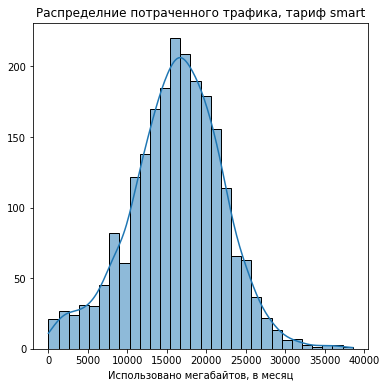

In [189]:
# Зададим гистограммы для распределений
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=s_analysis_df['mb_used'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Использовано мегабайтов, в месяц')
ax_1.axes.set_title('Распределние потраченного трафика, тариф smart', fontsize=12)
plt.show()

Распределение подобно нормальному, слегка скошено вправо

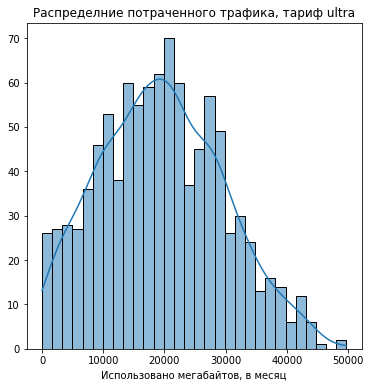

In [190]:
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=u_analysis_df['mb_used'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Использовано мегабайтов, в месяц')
ax_1.axes.set_title('Распределние потраченного трафика, тариф ultra', fontsize=12)
plt.show()

Распределение меньше похоже на нормальное, чем в тарифе smart \
Такая ситуация могла сложиться из-за неравномерности выборок - количество данных в тарифе smart первышает в ultra

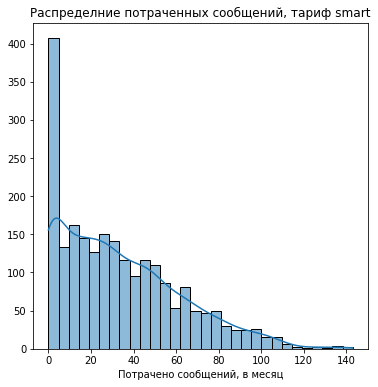

In [191]:
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=s_analysis_df['messages'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Потрачено сообщений, в месяц')
ax_1.axes.set_title('Распределние потраченных сообщений, тариф smart', fontsize=12)
plt.show()

Распределение не нормальное, с огромным количество нулевых данных. Такие данные легко объясняются неактуальностью смс-сообщений

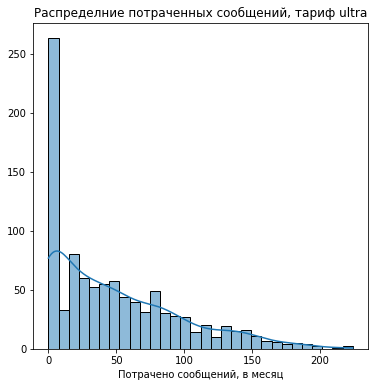

In [192]:
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=u_analysis_df['messages'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Потрачено сообщений, в месяц')
ax_1.axes.set_title('Распределние потраченных сообщений, тариф ultra', fontsize=12)
plt.show()

Абсолютно та же ситуация

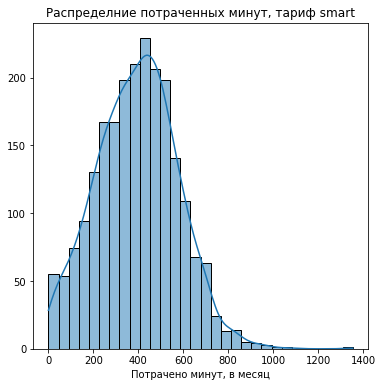

In [193]:
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=s_analysis_df['month_duration'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Потрачено минут, в месяц')
ax_1.axes.set_title('Распределние потраченных минут, тариф smart', fontsize=12)
plt.show()

У данных сильный "хвост" справа, много выбросов

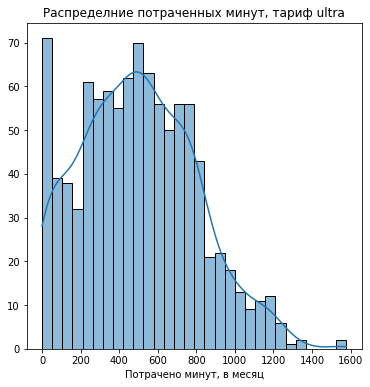

In [194]:
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=u_analysis_df['month_duration'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Потрачено минут, в месяц')
ax_1.axes.set_title('Распределние потраченных минут, тариф ultra', fontsize=12)
plt.show()

Много нулевых значений, небольшой "хвост" справа. В целом напоминает график по тарифу smart, но с особенностью в нулевых значениях

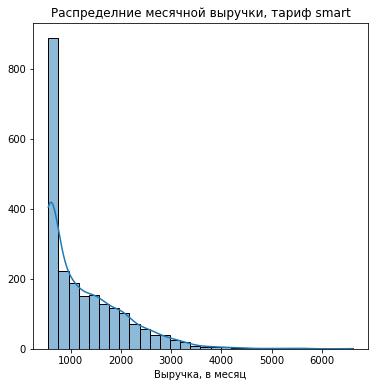

In [195]:
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=s_analysis_df['total_rev'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Выручка, в месяц')
ax_1.axes.set_title('Распределние месячной выручки, тариф smart', fontsize=12)
plt.show()

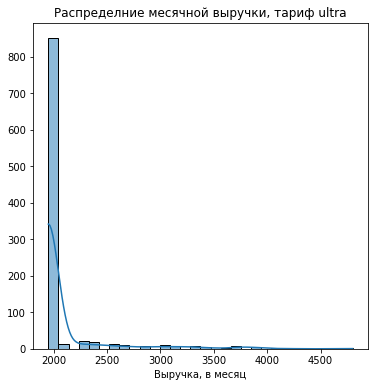

In [196]:
plt.figure(figsize=(6,6))
ax_1 = sns.histplot(data=u_analysis_df['total_rev'], bins=30, kde=True)
plt.ylabel('')
plt.xlabel('Выручка, в месяц')
ax_1.axes.set_title('Распределние месячной выручки, тариф ultra', fontsize=12)
plt.show()

Сравнив графики можно сказать, что пользователи тарифа smart гораздо чаще выходят за рамки лимита и доплачивают, пользователи ultra - реже

### Проверка гипотез

Есть задача проверить две основные гипотезы:
1) Средняя выручка пользователей тарифов smart и ultra различаются (не имеет значения, в какую сторону) \
2) Средняя выручка пользователей из Москвы и других город различаются (не имеет значения, в какую сторону)

Сформулируем нулевую и альтернативную гипотезы для каждого случая на основании того, что среднии выручки равны, альтернативные соответсвенно будут гласить обратное\
Начнём с различий тарифов 

Н0: Различий между средними выручками нет \
НА: Различия между средними выручками есть (в любую сторону)

Для этого используем t-критерий Стьюдента по независимым выборкам \
Пороговое значение примем как 0.05

In [197]:
alpha = .05

In [198]:
result = st.ttest_ind(u_analysis_df['total_rev'], s_analysis_df['total_rev'])

print(f'''
p-значение - {result[1]}
Среднее значение в smart - {np.mean(s_analysis_df['total_rev'])}
Среднее значение в ultra - {np.mean(u_analysis_df['total_rev'])}''')


p-значение - 1.513773301175091e-178
Среднее значение в smart - 1257.5886047554957
Среднее значение в ultra - 2070.1522842639592


In [205]:
if result[1] < alpha:
    print("Нулевая гипотеза отвергнута")
else:
    print("Нулевая гипотеза не отвергнута")

Нулевая гипотеза не отвергнута


Можно сделать вывод, что с определённой долей вероятности выручка тарифов различается

Перейдём к различию средней выручки между жителями Москвы и других городов

Н0: Различий между средними выручками жителей Москвы и других городов нет \
НА: Различия между средними выручками жителей Москвы и других городов есть

Применим тот же метод, что и в прошлый раз

In [200]:
# Для этого придётся приклеить данные про город
analysis_df = analysis_df.merge(users[['user_id', 'city']], left_on='user_id', right_on='user_id')

In [201]:
moscow_analysis_df = analysis_df.loc[analysis_df['city'] == 'Москва']
not_moscow_analysis_df = analysis_df.loc[analysis_df['city'] != 'Москва']

In [202]:
result = st.ttest_ind(moscow_analysis_df['total_rev'] 
                      ,not_moscow_analysis_df['total_rev'])

print(f'''
p-значение - {result[1]}
Среднее значение в Москве - {np.mean(moscow_analysis_df['total_rev'])}
Среднее значение не в Москве - {np.mean(not_moscow_analysis_df['total_rev'])} ''')


p-значение - 0.4836504757759247
Среднее значение в Москве - 1526.8379705400982
Среднее значение не в Москве - 1501.8697656550135 


In [204]:
if result[1] < alpha:
    print("Нулевая гипотеза отвергнута")
else:
    print("Нулевая гипотеза не отвергнута")

Нулевая гипотеза не отвергнута


Можно сделать вывод, что как таковой разницы между средними выручками нет

## Общий вывод

Из проведённого исследования можно сделать следующие выводы:

1) Пользователи тарифа ultra менее охотно выходят за рамки лимита, чем пользователи smart. Это может быть связано с более гораздо более широким лимитом \
2) В среднем выходят за рамки лимита только пользователи smart в категории трафика \
3) Пользователи ultra приносят нам больше выручки \
4) Нет явных статистических различий между выручками пользователей из Москвы и из других городов \
5) Сообщения не пользуются популярностью ни у одного тарифа

Обобщая всё вышесказанное можно заключить - тариф ultra для компании выгоднее, т.к. в среднем выручка с него больше, а затраты на обслуживание (имеется ввиду, что каждый потраченный пользователем мегабайт, минута и т.д. стоят для компании определённых расходов на поддержание работоспосбности инфраструктуры) не намного больше